In [ ]:
'''셀1
시뮬레이션에 필요한 library import
'''
from datetime import datetime,timedelta
import numpy as np
from scipy.stats import lognorm
import scipy.stats as stats
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#코랩 환경을 위한 라이브러리 (실행 환경에 맞게 설정)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''셀2
시뮬레이션에 필요한 변수를 사전에 정의
'''
#대기시간 가치
ALPAH=7851/3600 #초/원
#통행시간 가치
BETA=4676/3600 #초/원

#시뮬레이션이 결정론적이지 않게 하기 위해, 버스 출발시간에 -29~+30초 중 하나를 더한 시간에 출발
random_numbers = [0]
random_numbers += [random.randint(-29, 30) for _ in range(199)]

#로그분포 생성
shape = 1
scale = 10
x_values = np.arange(1, 92, 1)
probabilities = np.array([
    lognorm.cdf(x + 1, shape, scale=scale) - lognorm.cdf(x, shape, scale=scale)
    for x in x_values
])
probabilities /= probabilities.sum()
probabilities *=1 #1을 k라는 숫자로 바꾸면, 지하철-버스 환승객이 k배 된 효과

In [ ]:
'''셀3
버스 클래스
'''
class Bus708_south: #서울역 방면 버스 클래스

    #첫 출발시간. 데이터의 한계로 실제 첫차시간과 다르게, 6시 10분을 첫차시간으로 설정
    first_start_time=datetime.strptime("06:10", "%H:%M")

    #버스의 배차간격
    interval = 600

    #버스 노선에 있는 정류장 번호
    route = [
    12469, 35160, 12425, 12426, 12227, 12229, 12432, 12457, 12430, 12436,
    12112, 12014, 12016, 12018, 12020, 12022, 12024, 12026, 12028, 13026,
    13028, 13030, 13031, 13033, 13034, 13036, 13038, 13039
    ]

    #시점 정류장에서 해당 정류장까지의 이동시간: 네이버지도 기준
    route_time=[0, 60, 300, 360, 420, 450, 540, 600, 660, 720,
                900, 1080, 1140, 1320, 1380, 1500, 1620, 1680, 1800, 1920,
                2100, 2220, 2280, 2340, 2460, 2580, 2640, 2760]
    random_numbers=random_numbers

    point_idx=10
    by_station_per=0.6

    def __init__(self, id):
        self.id = id  # 버스 ID:0,1,2,3,4...
        self.start_time=id*Bus708_south.interval+Bus708_south.random_numbers[id]
        self.in_person=0
        self.optimal_time=0
        self.pi=0

class Bus708_north:
    first_start_time=datetime.strptime("06:10", "%H:%M")
    interval = 600
    route = [2123,2128,2137,1118,1114,1113,13035,13032,13040,13029,
             13027,12027,12025,12023,12021,12019,12017,12015,12013,12451,
             12111,12429,12435,12453,12431,12455,12456,12239,12238,12240,
             12424,12470]#32
    route_time=[0, 180, 300, 360, 540, 600, 780, 900, 960, 1020,
                1260, 1380, 1440, 1560, 1680, 1800, 1860, 1980, 2100, 2220,
                2400, 2520, 2640, 2670, 2700, 2760, 2820, 2880, 2940, 3000,
                3120, 3240]
    random_numbers=random_numbers

    point_idx=20
    by_station_per=0.8

    def __init__(self, id):
        self.id = id  # 버스 ID:0,1,2,3,4...
        self.start_time=id*Bus708_north.interval+Bus708_north.random_numbers[id]
        self.in_person=0
        self.optimal_time=0
        self.pi=0


In [ ]:
'''셀4
지하철 클래스
'''
class Subway_gupabal: #구파발역 지하철 클래스
    time_for_transfer=240

    time_to_zichuk=[ #지축 방면 구파발역 열차 도착 시간(네이버지도 평일 기준)
    datetime.strptime("05:56", "%H:%M"),#0
    datetime.strptime("06:13", "%H:%M"),#1
    datetime.strptime("06:29", "%H:%M"),
    datetime.strptime("06:35", "%H:%M"),
    datetime.strptime("06:42", "%H:%M"),
    datetime.strptime("06:54", "%H:%M"),
    datetime.strptime("07:05", "%H:%M"),#6
    datetime.strptime("07:14", "%H:%M"),
    datetime.strptime("07:25", "%H:%M"),
    datetime.strptime("07:29", "%H:%M"),
    datetime.strptime("07:39", "%H:%M"),
    datetime.strptime("07:44", "%H:%M"),
    datetime.strptime("07:49", "%H:%M"),
    datetime.strptime("07:53", "%H:%M"),
    datetime.strptime("07:57", "%H:%M"),
    datetime.strptime("08:05", "%H:%M"),#15
    datetime.strptime("08:14", "%H:%M"),
    datetime.strptime("08:22", "%H:%M"),
    datetime.strptime("08:27", "%H:%M"),
    datetime.strptime("08:31", "%H:%M"),
    datetime.strptime("08:39", "%H:%M"),
    datetime.strptime("08:46", "%H:%M"),
    datetime.strptime("08:54", "%H:%M"),
    datetime.strptime("09:04", "%H:%M"),#23
    datetime.strptime("09:11", "%H:%M"),
    datetime.strptime("09:19", "%H:%M"),
    datetime.strptime("09:23", "%H:%M"),
    datetime.strptime("09:31", "%H:%M"),
    datetime.strptime("09:41", "%H:%M"),
    datetime.strptime("09:52", "%H:%M"),
    datetime.strptime("09:57", "%H:%M"),
    datetime.strptime("10:02", "%H:%M"),#31
    datetime.strptime("10:14", "%H:%M"),
    datetime.strptime("10:18", "%H:%M"),
    datetime.strptime("10:25", "%H:%M"),
    datetime.strptime("10:32", "%H:%M"),
    datetime.strptime("10:43", "%H:%M"),
    datetime.strptime("10:57", "%H:%M"),
    datetime.strptime("11:03", "%H:%M"),#38
    datetime.strptime("11:14", "%H:%M"),
    datetime.strptime("11:26", "%H:%M"),
    datetime.strptime("11:33", "%H:%M"),
    datetime.strptime("11:39", "%H:%M"),
    datetime.strptime("11:53", "%H:%M"),
    datetime.strptime("12:07", "%H:%M"),#44
    datetime.strptime("12:14", "%H:%M"),
    datetime.strptime("12:20", "%H:%M"),
    datetime.strptime("12:35", "%H:%M"),
    datetime.strptime("12:43", "%H:%M"),
    datetime.strptime("12:52", "%H:%M"),
    datetime.strptime("13:03", "%H:%M"),#50
    datetime.strptime("13:11", "%H:%M"),
    datetime.strptime("13:21", "%H:%M"),
    datetime.strptime("13:28", "%H:%M"),
    datetime.strptime("13:44", "%H:%M"),
    datetime.strptime("13:51", "%H:%M"),
    datetime.strptime("13:58", "%H:%M"),
    datetime.strptime("14:11", "%H:%M"),#57
    datetime.strptime("14:17", "%H:%M"),
    datetime.strptime("14:30", "%H:%M"),
    datetime.strptime("14:43", "%H:%M"),
    datetime.strptime("14:50", "%H:%M"),
    datetime.strptime("14:57", "%H:%M"),
    datetime.strptime("15:12", "%H:%M"),#63
    datetime.strptime("15:21", "%H:%M"),
    datetime.strptime("15:30", "%H:%M"),
    datetime.strptime("15:39", "%H:%M"),
    datetime.strptime("15:48", "%H:%M"),
    datetime.strptime("15:57", "%H:%M"),
    datetime.strptime("16:05", "%H:%M"),#69
    datetime.strptime("16:12", "%H:%M"),
    datetime.strptime("16:27", "%H:%M"),
    datetime.strptime("16:32", "%H:%M"),
    datetime.strptime("16:38", "%H:%M"),
    datetime.strptime("16:50", "%H:%M"),
    datetime.strptime("17:02", "%H:%M"),#75
    datetime.strptime("17:08", "%H:%M"),
    datetime.strptime("17:14", "%H:%M"),
    datetime.strptime("17:22", "%H:%M"),
    datetime.strptime("17:30", "%H:%M"),
    datetime.strptime("17:38", "%H:%M"),
    datetime.strptime("17:46", "%H:%M"),
    datetime.strptime("17:55", "%H:%M"),
    datetime.strptime("18:08", "%H:%M"),#83
    datetime.strptime("18:19", "%H:%M"),
    datetime.strptime("18:28", "%H:%M"),
    datetime.strptime("18:38", "%H:%M"),
    datetime.strptime("18:48", "%H:%M"),
    datetime.strptime("18:52", "%H:%M"),
    datetime.strptime("19:01", "%H:%M"),#89
    datetime.strptime("19:10", "%H:%M"),
    datetime.strptime("19:18", "%H:%M"),
    datetime.strptime("19:27", "%H:%M"),
    datetime.strptime("19:35", "%H:%M"),
    datetime.strptime("19:45", "%H:%M"),
    datetime.strptime("19:55", "%H:%M"),
    datetime.strptime("20:05", "%H:%M"),#96
    datetime.strptime("20:10", "%H:%M"),
    datetime.strptime("20:16", "%H:%M"),
    datetime.strptime("20:26", "%H:%M"),
    datetime.strptime("20:37", "%H:%M"),
    datetime.strptime("20:43", "%H:%M"),
    datetime.strptime("20:54", "%H:%M"),
    datetime.strptime("21:05", "%H:%M"),#103
    datetime.strptime("21:15", "%H:%M"),
    datetime.strptime("21:25", "%H:%M"),
    datetime.strptime("21:36", "%H:%M"),
    datetime.strptime("21:42", "%H:%M"),
    datetime.strptime("21:48", "%H:%M"),
    datetime.strptime("21:59", "%H:%M"),
    datetime.strptime("22:05", "%H:%M"),#110
    datetime.strptime("22:15", "%H:%M"),
    datetime.strptime("22:26", "%H:%M"),
    datetime.strptime("22:40", "%H:%M"),
    datetime.strptime("22:47", "%H:%M"),
    datetime.strptime("23:01", "%H:%M"),#115
    datetime.strptime("23:10", "%H:%M"),
    datetime.strptime("23:26", "%H:%M"),
    datetime.strptime("23:42", "%H:%M"),
    datetime.strptime("00:09", "%H:%M"),#119
    ]
    #각 시간마다 첫 도착 열차의 인덱스
    #ex.time_to_zichuk의 1번째 index에서 6시 처음 열차 도착
    #ex.time_to_zichuk의 6번째 index에서 7시 처음 열차 도착
    index_zichuk=[1,6,15,23,31,38,44,50,57,63,69,75,83,89,96,103,110,115,119]



    time_to_yeonsinnae=[ #연신내 방면 구파발역 열차 도착 시간(네이버지도 평일 기준)
    datetime.strptime("05:30", "%H:%M"),#0
    datetime.strptime("05:38", "%H:%M"),
    datetime.strptime("05:47", "%H:%M"),
    datetime.strptime("05:56", "%H:%M"),
    datetime.strptime("06:03", "%H:%M"),#4
    datetime.strptime("06:09", "%H:%M"),
    datetime.strptime("06:15", "%H:%M"),
    datetime.strptime("06:22", "%H:%M"),
    datetime.strptime("06:28", "%H:%M"),
    datetime.strptime("06:33", "%H:%M"),
    datetime.strptime("06:39", "%H:%M"),
    datetime.strptime("06:45", "%H:%M"),
    datetime.strptime("06:51", "%H:%M"),
    datetime.strptime("06:56", "%H:%M"),
    datetime.strptime("07:01", "%H:%M"),#14
    datetime.strptime("07:05", "%H:%M"),
    datetime.strptime("07:09", "%H:%M"),
    datetime.strptime("07:13", "%H:%M"),
    datetime.strptime("07:17", "%H:%M"),
    datetime.strptime("07:21", "%H:%M"),
    datetime.strptime("07:27", "%H:%M"),
    datetime.strptime("07:31", "%H:%M"),
    datetime.strptime("07:34", "%H:%M"),
    datetime.strptime("07:38", "%H:%M"),
    datetime.strptime("07:42", "%H:%M"),
    datetime.strptime("07:46", "%H:%M"),
    datetime.strptime("07:49", "%H:%M"),
    datetime.strptime("07:53", "%H:%M"),
    datetime.strptime("07:57", "%H:%M"),
    datetime.strptime("08:01", "%H:%M"),#29
    datetime.strptime("08:04", "%H:%M"),
    datetime.strptime("08:07", "%H:%M"),
    datetime.strptime("08:11", "%H:%M"),
    datetime.strptime("08:16", "%H:%M"),
    datetime.strptime("08:19", "%H:%M"),
    datetime.strptime("08:24", "%H:%M"),
    datetime.strptime("08:27", "%H:%M"),
    datetime.strptime("08:30", "%H:%M"),
    datetime.strptime("08:33", "%H:%M"),
    datetime.strptime("08:37", "%H:%M"),
    datetime.strptime("08:41", "%H:%M"),
    datetime.strptime("08:45", "%H:%M"),
    datetime.strptime("08:49", "%H:%M"),
    datetime.strptime("08:53", "%H:%M"),
    datetime.strptime("08:57", "%H:%M"),
    datetime.strptime("09:01", "%H:%M"),#45
    datetime.strptime("09:05", "%H:%M"),
    datetime.strptime("09:09", "%H:%M"),
    datetime.strptime("09:13", "%H:%M"),
    datetime.strptime("09:18", "%H:%M"),
    datetime.strptime("09:23", "%H:%M"),
    datetime.strptime("09:28", "%H:%M"),
    datetime.strptime("09:33", "%H:%M"),
    datetime.strptime("09:38", "%H:%M"),
    datetime.strptime("09:44", "%H:%M"),
    datetime.strptime("09:50", "%H:%M"),
    datetime.strptime("09:56", "%H:%M"),
    datetime.strptime("10:01", "%H:%M"),#57
    datetime.strptime("10:07", "%H:%M"),
    datetime.strptime("10:14", "%H:%M"),
    datetime.strptime("10:21", "%H:%M"),
    datetime.strptime("10:28", "%H:%M"),
    datetime.strptime("10:36", "%H:%M"),
    datetime.strptime("10:45", "%H:%M"),
    datetime.strptime("10:52", "%H:%M"),
    datetime.strptime("10:58", "%H:%M"),
    datetime.strptime("11:04", "%H:%M"),#66
    datetime.strptime("11:11", "%H:%M"),
    datetime.strptime("11:17", "%H:%M"),
    datetime.strptime("11:23", "%H:%M"),
    datetime.strptime("11:30", "%H:%M"),
    datetime.strptime("11:36", "%H:%M"),
    datetime.strptime("11:43", "%H:%M"),
    datetime.strptime("11:50", "%H:%M"),
    datetime.strptime("11:56", "%H:%M"),
    datetime.strptime("12:01", "%H:%M"),#75
    datetime.strptime("12:08", "%H:%M"),
    datetime.strptime("12:15", "%H:%M"),
    datetime.strptime("12:22", "%H:%M"),
    datetime.strptime("12:29", "%H:%M"),
    datetime.strptime("12:36", "%H:%M"),
    datetime.strptime("12:43", "%H:%M"),
    datetime.strptime("12:50", "%H:%M"),
    datetime.strptime("12:59", "%H:%M"),
    datetime.strptime("13:08", "%H:%M"),#84
    datetime.strptime("13:18", "%H:%M"),
    datetime.strptime("13:27", "%H:%M"),
    datetime.strptime("13:35", "%H:%M"),
    datetime.strptime("13:44", "%H:%M"),
    datetime.strptime("13:52", "%H:%M"),
    datetime.strptime("13:59", "%H:%M"),
    datetime.strptime("14:06", "%H:%M"),#91
    datetime.strptime("14:12", "%H:%M"),
    datetime.strptime("14:18", "%H:%M"),
    datetime.strptime("14:25", "%H:%M"),
    datetime.strptime("14:31", "%H:%M"),
    datetime.strptime("14:38", "%H:%M"),
    datetime.strptime("14:45", "%H:%M"),
    datetime.strptime("14:52", "%H:%M"),
    datetime.strptime("14:58", "%H:%M"),
    datetime.strptime("15:05", "%H:%M"),#100
    datetime.strptime("15:11", "%H:%M"),
    datetime.strptime("15:18", "%H:%M"),
    datetime.strptime("15:26", "%H:%M"),
    datetime.strptime("15:35", "%H:%M"),
    datetime.strptime("15:45", "%H:%M"),
    datetime.strptime("15:54", "%H:%M"),
    datetime.strptime("16:03", "%H:%M"),#107
    datetime.strptime("16:12", "%H:%M"),
    datetime.strptime("16:20", "%H:%M"),
    datetime.strptime("16:28", "%H:%M"),
    datetime.strptime("16:35", "%H:%M"),
    datetime.strptime("16:41", "%H:%M"),
    datetime.strptime("16:46", "%H:%M"),
    datetime.strptime("16:51", "%H:%M"),
    datetime.strptime("16:56", "%H:%M"),
    datetime.strptime("17:00", "%H:%M"),#116
    datetime.strptime("17:04", "%H:%M"),
    datetime.strptime("17:08", "%H:%M"),
    datetime.strptime("17:12", "%H:%M"),
    datetime.strptime("17:16", "%H:%M"),
    datetime.strptime("17:20", "%H:%M"),
    datetime.strptime("17:25", "%H:%M"),
    datetime.strptime("17:28", "%H:%M"),
    datetime.strptime("17:35", "%H:%M"),
    datetime.strptime("17:41", "%H:%M"),
    datetime.strptime("17:46", "%H:%M"),
    datetime.strptime("17:51", "%H:%M"),
    datetime.strptime("17:56", "%H:%M"),
    datetime.strptime("18:00", "%H:%M"),#129
    datetime.strptime("18:04", "%H:%M"),
    datetime.strptime("18:08", "%H:%M"),
    datetime.strptime("18:13", "%H:%M"),
    datetime.strptime("18:16", "%H:%M"),
    datetime.strptime("18:21", "%H:%M"),
    datetime.strptime("18:24", "%H:%M"),
    datetime.strptime("18:28", "%H:%M"),
    datetime.strptime("18:32", "%H:%M"),
    datetime.strptime("18:36", "%H:%M"),
    datetime.strptime("18:40", "%H:%M"),
    datetime.strptime("18:45", "%H:%M"),
    datetime.strptime("18:50", "%H:%M"),
    datetime.strptime("18:53", "%H:%M"),
    datetime.strptime("18:58", "%H:%M"),
    datetime.strptime("19:03", "%H:%M"),#144
    datetime.strptime("19:08", "%H:%M"),
    datetime.strptime("19:13", "%H:%M"),
    datetime.strptime("19:18", "%H:%M"),
    datetime.strptime("19:23", "%H:%M"),
    datetime.strptime("19:28", "%H:%M"),
    datetime.strptime("19:34", "%H:%M"),
    datetime.strptime("19:38", "%H:%M"),
    datetime.strptime("19:43", "%H:%M"),
    datetime.strptime("19:48", "%H:%M"),
    datetime.strptime("19:53", "%H:%M"),
    datetime.strptime("19:58", "%H:%M"),
    datetime.strptime("20:03", "%H:%M"),#156
    datetime.strptime("20:09", "%H:%M"),
    datetime.strptime("20:14", "%H:%M"),
    datetime.strptime("20:19", "%H:%M"),
    datetime.strptime("20:25", "%H:%M"),
    datetime.strptime("20:30", "%H:%M"),
    datetime.strptime("20:35", "%H:%M"),
    datetime.strptime("20:40", "%H:%M"),
    datetime.strptime("20:45", "%H:%M"),
    datetime.strptime("20:52", "%H:%M"),#165
    datetime.strptime("21:00", "%H:%M"),
    datetime.strptime("21:05", "%H:%M"),
    datetime.strptime("21:12", "%H:%M"),
    datetime.strptime("21:17", "%H:%M"),
    datetime.strptime("21:23", "%H:%M"),
    datetime.strptime("21:32", "%H:%M"),
    datetime.strptime("21:42", "%H:%M"),
    datetime.strptime("21:49", "%H:%M"),
    datetime.strptime("21:56", "%H:%M"),
    datetime.strptime("22:04", "%H:%M"),#175
    datetime.strptime("22:10", "%H:%M"),
    datetime.strptime("22:16", "%H:%M"),
    datetime.strptime("22:25", "%H:%M"),
    datetime.strptime("22:34", "%H:%M"),
    datetime.strptime("22:42", "%H:%M"),
    datetime.strptime("22:51", "%H:%M"),
    datetime.strptime("23:01", "%H:%M"),#182
    datetime.strptime("23:11", "%H:%M"),
    datetime.strptime("23:25", "%H:%M"),
    datetime.strptime("23:35", "%H:%M"),
    datetime.strptime("23:44", "%H:%M"),
    datetime.strptime("23:53", "%H:%M"),
    datetime.strptime("00:02", "%H:%M"),#188
    datetime.strptime("00:11", "%H:%M"),
    datetime.strptime("00:34", "%H:%M"),
    ]
    index_yeonsinnae=[0,4,14,29,45,57,66,75,84,91,100,107,116,129,144,156,165,175,182,188]

    @classmethod
    #전열차와 해당 열차의 도착시간 차이.
    #ex.전열차가 7:00 도착이고, 해당 열차가 7:08분 도착이면, (8분*60초/분)이 들어감
    def initialize(cls):

        cls.time_differences_zichuk = [0] + [
            (cls.time_to_zichuk[i] - cls.time_to_zichuk[i-1]).seconds
            for i in range(1, len(cls.time_to_zichuk))
        ]

        cls.time_differences_yeonsinnae = [0] + [
            (cls.time_to_yeonsinnae[i] - cls.time_to_yeonsinnae[i-1]).seconds
            for i in range(1, len(cls.time_to_yeonsinnae))
        ]

#구파발역 환승센터 클래스 객체 생성해 두기.
gupa=Subway_gupabal()
gupa.initialize()

In [ ]:
'''셀5
1월 데이터 로드 및 전처리(과거 데이터로 활용할 파일 로드)
'''
# CSV 파일 불러오기
file_path = '/content/drive/My Drive/2025년_버스노선별_정류장별_시간대별_승하차_인원_정보(01월).csv'
df = pd.read_csv(file_path, encoding='cp949', dtype={'열이름': str})

# '노선번호'가 708번인 데이터만 필터링 + 필요한 열만 선택
columns = ['버스정류장ARS번호'] + [f'{hour}시승차총승객수' for hour in range(6, 24)] + [f'{hour}시하차총승객수' for hour in range(6, 24)]
df = df[df['노선번호'] == '708'][columns]

# '버스정류장ARS번호'를 정수형 변환 후 리스트에 있는 정류장만 필터링
df['버스정류장ARS번호'] = df['버스정류장ARS번호'].astype(int)
df = df[df['버스정류장ARS번호'].isin(Bus708_south.route)]

# 정류장 순서대로 정렬
df['버스정류장ARS번호'] = pd.Categorical(df['버스정류장ARS번호'], categories=Bus708_south.route, ordered=True)
df = df.sort_values('버스정류장ARS번호')

# 초당 승·하차 승객수 계산
for hour in range(6, 24):
    df[f'{hour}시초당승차총승객수'] = df[f'{hour}시승차총승객수'] / (3600 * 31)
    df[f'{hour}시초당하차총승객수'] = df[f'{hour}시하차총승객수'] / (3600 * 31)

#정류장 번호가 여러개로 나누어진게 있어서, 그 문제 해결
df = df.groupby("버스정류장ARS번호", as_index=False, observed=False).sum()
df_filtered_train=df.copy()
df=None



'''
2월 데이터 로드 및 전처리(과거 데이터로 활용할 파일 로드)
'''

file_path = '/content/drive/My Drive/2025년_버스노선별_정류장별_시간대별_승하차_인원_정보(02월).csv'
df = pd.read_csv(file_path, encoding='cp949', dtype={'열이름': str})
columns = ['버스정류장ARS번호'] + [f'{hour}시승차총승객수' for hour in range(6, 24)] + [f'{hour}시하차총승객수' for hour in range(6, 24)]
df = df[df['노선번호'] == '708'][columns]
df['버스정류장ARS번호'] = df['버스정류장ARS번호'].astype(int)
df = df[df['버스정류장ARS번호'].isin(Bus708_south.route)]
df['버스정류장ARS번호'] = pd.Categorical(df['버스정류장ARS번호'], categories=Bus708_south.route, ordered=True)
df = df.sort_values('버스정류장ARS번호')
for hour in range(6, 24):
    df[f'{hour}시초당승차총승객수'] = df[f'{hour}시승차총승객수'] / (3600 * 28)
    df[f'{hour}시초당하차총승객수'] = df[f'{hour}시하차총승객수'] / (3600 * 28)
df = df.groupby("버스정류장ARS번호", as_index=False, observed=False).sum()
df_filtered_test=df.copy()

<ipython-input-84-25769d9fbffc>:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', dtype={'열이름': str})
<ipython-input-84-25769d9fbffc>:37: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', dtype={'열이름': str})


In [ ]:
'''셀6
수요 데이터 생성
과거 데이터로부터 초당 승객 생성 기대값 생성.
ex. [0.02, 0.02, 0.03...]이런식으로 초당 0.02명의 승객이 생성되는 것이 기대값

반면, 테스트 데이터는 승객을 실제 정수로 생성
[0.02, 0.02, 0.03...]이면, 0.02는 98%확률로 0명의 승객이 생성, 2%확률로 1명의 승객이 생성
추가로 1.7이면, 30%확률로 1명의 승객이 생성, 70%확률로 1명의 승객이 생성
즉 기대값을 정수로 바꾼 것.

모든 정류장에 대하여 다음 과정을 반복.
'''

#각 정류장에 대하여 초당 승차 기대값과 초당 하차 기대값을 리스트로 생성.
#이때 하차 데이터는 분석 정류장 이전 정류장에 대해서만 필요함.
list_length = 3600*20

board_dict = {}
drop_dict={}


#분석 정류장 이전 정류장에 대하여 승차 및 하차 기대값 계산
for i in range(0,Bus708_south.point_idx):
  board_dict[f"board_{i}"] = [0] * list_length
  drop_dict[f"drop_{i}"] = [0] * list_length
  for j in range(0,18):
    temp=6+j
    for k in range(0,3600):
      board_dict[f"board_{i}"][j*3600+k]+=df_filtered_train[f'{temp}시초당승차총승객수'].iloc[i]
      drop_dict[f"drop_{i}"][j*3600+k]+=df_filtered_train[f'{temp}시초당하차총승객수'].iloc[i]
drop_dict[f"drop_{Bus708_south.point_idx}"]= [0] * list_length


#분석 정류장의 하차 기대값
for j in range(0,18):
  temp=6+j
  for k in range(0,3600):
    drop_dict[f"drop_{Bus708_south.point_idx}"][j*3600+k]+=df_filtered_train[f'{temp}시초당하차총승객수'].iloc[Bus708_south.point_idx]


#분석 정류장 이후 정류장의 승차 기대값
for i in range(Bus708_south.point_idx+1,len(Bus708_south.route)):
  board_dict[f"board_{i}"] = [0] * list_length
  for j in range(0,18):
    for k in range(0,3600):
      board_dict[f"board_{i}"][j*3600+k]+=df_filtered_train[f'{temp}시초당승차총승객수'].iloc[i]



'''
지하철 환승객 수 계산한 논리.

지축방면과 연신내방면 중 어디 방면에서 내렸는지 알 수 있는 데이터가 없어, 50%씩 분배하였습니다.
예를 들어 4개의 도착한 지하철에서 100명의 승객이 내렸다 가정하자.
그중 첫번째는 이전 지하철 도착과 7분차이, 두번째는 이전 지하철 도착과 5분차이,
세번째는 이전 지하철 도착과 4분차이, 네번째는 이전 지하철 도착과 4분차이라 하자.

그러면 1번째 지하철에서 내린 승객은 100*7/(7+5+4+4)로 계산하였다.
왜냐면 이전 지하철과 도착이 7분 차이이면, 7분동안 이전 정류장들에 쌓인 승객을 데리고 왔을 것으로 예상할 수 있다.
'''
#구파발역 환승센터(분석 정류장)에서의 승객 분포는 지하철 환승객을 고려해야 함.
sum_time=0
demand_point = [0] * list_length
for i in range(0,18):
  temp=i+6
  temp_hour=df_filtered_train[f'{temp}시초당승차총승객수'].iloc[Bus708_south.point_idx]

  #지하철에서 오지 않은 승객을 균등분포로 배정해 두기.
  for j in range(0,3600):
    demand_point[i*3600+j]+=temp_hour * (1 - Bus708_south.by_station_per)

  #지하철에서 온 승객 계산. 알고리즘은 위의 설명에 기반.
  for z in range(gupa.index_zichuk[i],gupa.index_zichuk[i+1]):
    sum_time+=gupa.time_differences_zichuk[z]
  for y in range(gupa.index_yeonsinnae[i],gupa.index_yeonsinnae[i+1]):
    sum_time+=gupa.time_differences_yeonsinnae[y]
  for z in range(gupa.index_zichuk[i],gupa.index_zichuk[i+1]):
    for k in range(0,91,1):
      demand_point[i*3600+gupa.time_to_zichuk[z].minute*60+gupa.time_for_transfer+k]+=(
            probabilities[k]*
            temp_hour*3600*
            Bus708_south.by_station_per*
            gupa.time_differences_zichuk[z]/sum_time)
  for y in range(gupa.index_yeonsinnae[i],gupa.index_yeonsinnae[i+1]):
    for k in range(0,91,1):
      if i*3600+gupa.time_to_yeonsinnae[y].minute*60+gupa.time_for_transfer+k>3600*17+3500:
        print(i*3600+gupa.time_to_yeonsinnae[y].minute*60+gupa.time_for_transfer+k)
        print(gupa.time_to_yeonsinnae[y].hour)
        print(gupa.time_to_yeonsinnae[y].minute)
      demand_point[i*3600+gupa.time_to_yeonsinnae[y].minute*60+gupa.time_for_transfer+k]+=(
            probabilities[k]*
            temp_hour*3600*
            Bus708_south.by_station_per*
            gupa.time_differences_yeonsinnae[y]/sum_time)


  sum_time=0

#분석정류장의 승차 기대값은 다른 정류장과 다르게 지하철 환승객을 고려한 후, board_dict에 대입
board_dict[f"board_{Bus708_south.point_idx}"]=demand_point


In [ ]:
'''셀7
test 데이터로 부터 정수 승객값 생성.
구조는 위의 셀와 동일.
마지막 9줄이 정수로 바꾸기 위한 코드.
'''

board_dict_test = {}
drop_dict_test = {}
for i in range(0, Bus708_south.point_idx):
  board_dict_test[f"board_{i}"] = [0] * list_length
  drop_dict_test[f"drop_{i}"] = [0] * list_length
  for j in range(0,18):
    temp = 6+j
    for k in range(0,3600):
      board_dict_test[f"board_{i}"][j*3600+k] += df_filtered_test[f'{temp}시초당승차총승객수'].iloc[i]
      drop_dict_test[f"drop_{i}"][j*3600+k] += df_filtered_test[f'{temp}시초당하차총승객수'].iloc[i]


drop_dict_test[f"drop_{Bus708_south.point_idx}"] = [0] * list_length

for j in range(0,18):
  temp = 6+j
  for k in range(0,3600):
    drop_dict_test[f"drop_{Bus708_south.point_idx}"][j*3600+k] += df_filtered_test[f'{temp}시초당하차총승객수'].iloc[Bus708_south.point_idx]

for i in range(Bus708_south.point_idx+1, len(Bus708_south.route)):
  board_dict_test[f"board_{i}"] = [0] * list_length
  for j in range(0,18):
    for k in range(0,3600):
      board_dict_test[f"board_{i}"][j*3600+k] += df_filtered_test[f'{temp}시초당승차총승객수'].iloc[i]


demand_point = [0] * list_length
for i in range(0,18):
  temp = i+6
  temp_hour = df_filtered_test[f'{temp}시초당승차총승객수'].iloc[Bus708_south.point_idx]
  for j in range(0,3600):
    demand_point[i*3600+j] += temp_hour * (1 - Bus708_south.by_station_per)
  for z in range(gupa.index_zichuk[i], gupa.index_zichuk[i+1]):
    sum_time += gupa.time_differences_zichuk[z]
  for y in range(gupa.index_yeonsinnae[i], gupa.index_yeonsinnae[i+1]):
    sum_time += gupa.time_differences_yeonsinnae[y]

  for z in range(gupa.index_zichuk[i], gupa.index_zichuk[i+1]):
    for k in range(0, 91, 1):
      demand_point[i*3600 + gupa.time_to_zichuk[z].minute*60 + gupa.time_for_transfer + k] += (
            probabilities[k] *
            temp_hour*3600 *
            Bus708_south.by_station_per *
            gupa.time_differences_zichuk[z] / sum_time
      )
  for y in range(gupa.index_yeonsinnae[i], gupa.index_yeonsinnae[i+1]):
    for k in range(0, 91, 1):
      demand_point[i*3600 + gupa.time_to_yeonsinnae[y].minute*60 + gupa.time_for_transfer + k] += (
            probabilities[k] *
            temp_hour*3600 *
            Bus708_south.by_station_per *
            gupa.time_differences_yeonsinnae[y] / sum_time
      )
  sum_time = 0
board_dict_test[f"board_{Bus708_south.point_idx}"] = demand_point


#승객 생성 기대값을 정수로 변환
board_int_dict = {}
drop_int_dict={}
for i in range(0,len(Bus708_south.route)):
  board_int_dict[f"board_{i}"]=[int(p) + np.random.choice([0, 1], p=[1 - (p % 1), p % 1]) for p in board_dict[f"board_{i}"]]

for i in range(0,Bus708_south.point_idx+1):
  drop_int_dict[f"drop_{i}"]=[int(p) + np.random.choice([0, 1], p=[1 - (p % 1), p % 1]) for p in drop_dict[f"drop_{i}"]]


In [ ]:
'''셀8
버스의 출발시각에 따라 각 버스의 이익 기대값 및 실제 이익값을 계산하는 셀
'''

bus_dict = {} #편익 기대값을 계산하기 위한 가상의 버스 딕셔너리
bus_int_dict = {} #편익 기대값을 계산하기 위한 가상의 버스 딕셔너리
total_pi = 0
total_int_pi = 0
total_wait_num = 0
total_wait_time =0


bus_count = int(17 * 3600 / Bus708_south.interval) #6:10부터 총 17시간 운영

for i in range(bus_count):
    print("--------------------------------------------------------------------------------------------")
    print(f"{i+1}번째 버스")
    bus = Bus708_south(i)
    bus_dict[f"bus{i}"] = bus
    start_time = bus.start_time

    # in_person(내부 승객수) 계산: in_person값은 실제 승객 데이터로부터 생성. 버스가 대기를 결정할 때, in_person값은 실제 값을 알고 있으므로.
    in_person = 0
    k_start = 0 if i == 0 else bus_dict[f"bus{i-1}"].optimal_time
    for j in range(Bus708_south.point_idx):
        rtj = Bus708_south.route_time[j]
        for k in range(k_start, Bus708_south.interval):
            t = start_time + rtj + k
            in_person += board_int_dict[f"board_{j}"][t] - drop_int_dict[f"drop_{j}"][t]

    rtj = Bus708_south.route_time[Bus708_south.point_idx]
    for k in range(k_start, Bus708_south.interval):
        in_person -= drop_int_dict[f"drop_{Bus708_south.point_idx}"][start_time + rtj + k]

    bus.in_person = max(0, in_person)

    # 분석 정류장과 분석정류장 이후 정류장에 대하여 손실을 입은 사람 수 계산
    loss_person_0 = 0 #분석정류장에서 손실을 입은 사람 수
    loss_person_over1 = 0 #분석정류장 이후 정류장에서 손실을 입은 사람 수
    for j in range(Bus708_south.point_idx, len(Bus708_south.route)):
        rtj = Bus708_south.route_time[j]
        for k in range(k_start, Bus708_south.interval):
            val = board_dict[f"board_{j}"][start_time + rtj + k]
            if j == Bus708_south.point_idx:
                loss_person_0 += val
            else:
                loss_person_over1 += val

    # 최적 t 및 pi 계산
    max_pi = 0
    max_t = 0
    for t in range(int(Bus708_south.interval / 4)):
        plus = 0
        for j in range(Bus708_south.point_idx, len(Bus708_south.route)):
            rtj = Bus708_south.route_time[j]
            for p in range(t):
                val = board_dict[f"board_{j}"][start_time + rtj + p]
                if j == Bus708_south.point_idx:
                    plus += val * (ALPAH * (Bus708_south.interval - t) + (ALPAH - BETA) * (t - p))
                else:
                    plus += val * (ALPAH * (Bus708_south.interval - t))

        pi = (-(BETA * bus.in_person + BETA * loss_person_0 + ALPAH * loss_person_over1) * t + plus)
        if pi > max_pi:
            max_pi = pi
            max_t = t

    bus.pi = max_pi
    bus.optimal_time = max_t
    print(f"최적 대기시간: {bus.optimal_time}초")
    print(f"편익 기대값: {bus.pi}원")
    total_pi += bus.pi
    if bus.optimal_time > 0:
        total_wait_num += 1
        total_wait_time += bus.optimal_time


    # 실제 편익값을 구하기 위한 버스 딕셔너리인 int_dict도 생성
    bus_int = Bus708_south(i)
    bus_int_dict[f"bus{i}"] = bus_int
    start_time = bus_int.start_time

    # 손해를 입는 사람 수 계산
    loss_person_0 = 0
    loss_person_over1 = 0
    for j in range(Bus708_south.point_idx, len(Bus708_south.route)):
        rtj = Bus708_south.route_time[j]
        for k in range(k_start, Bus708_south.interval):
            val = board_int_dict[f"board_{j}"][start_time + rtj + k]
            if j == Bus708_south.point_idx:
                loss_person_0 += val
            else:
                loss_person_over1 += val

    loss_person_0 = max(0, loss_person_0)
    loss_person_over1 = max(0, loss_person_over1)

    # 과거 데이터로 부터 얻은 t값을 통해 실제 이익(pi)계산
    t = bus.optimal_time
    plus = 0
    if t > 0:
        for j in range(Bus708_south.point_idx, len(Bus708_south.route)):
            rtj = Bus708_south.route_time[j]
            for p in range(t):
                val = board_dict[f"board_{j}"][start_time + rtj + p]
                if j == Bus708_south.point_idx:
                    plus += val * (ALPAH * (Bus708_south.interval - t) + (ALPAH - BETA) * (t - p))
                else:
                    plus += val * (ALPAH * (Bus708_south.interval - t))

        pi = (-(BETA * bus.in_person + BETA * loss_person_0 + ALPAH * loss_person_over1) * t + plus)
        bus_int.pi = pi
        bus_int.optimal_time = t
        print(f"편익 실제값: {bus_int.pi}원")
        total_int_pi += pi
    else:
        print(f"편익 실제값: {bus_int.pi}원")
    print("\n")

print("--------------------------------------------------------------------------------------------")
print("********************************************************************************************")
# 하루동안의 최종 이익 계산

print(f"하루동안의 총 대기 횟수: {total_wait_num}회")
print(f"하루동안의 총 대기 시간의 합: {total_wait_time}초")
print(f"하루동안의 총 편익 기대값의 합: {total_pi}원")
print(f"하루동안의 총 편익 기대값의 합: {total_int_pi}원")

print("********************************************************************************************")

--------------------------------------------------------------------------------------------
1번째 버스
최적 대기시간: 0초
편익 기대값: 0원
편익 실제값: 0원


--------------------------------------------------------------------------------------------
2번째 버스
최적 대기시간: 0초
편익 기대값: 0원
편익 실제값: 0원


--------------------------------------------------------------------------------------------
3번째 버스
최적 대기시간: 0초
편익 기대값: 0원
편익 실제값: 0원


--------------------------------------------------------------------------------------------
4번째 버스
최적 대기시간: 0초
편익 기대값: 0원
편익 실제값: 0원


--------------------------------------------------------------------------------------------
5번째 버스
최적 대기시간: 0초
편익 기대값: 0원
편익 실제값: 0원


--------------------------------------------------------------------------------------------
6번째 버스
최적 대기시간: 0초
편익 기대값: 0원
편익 실제값: 0원


--------------------------------------------------------------------------------------------
7번째 버스
최적 대기시간: 0초
편익 기대값: 0원
편익 실제값: 0원


------------------------------------------------

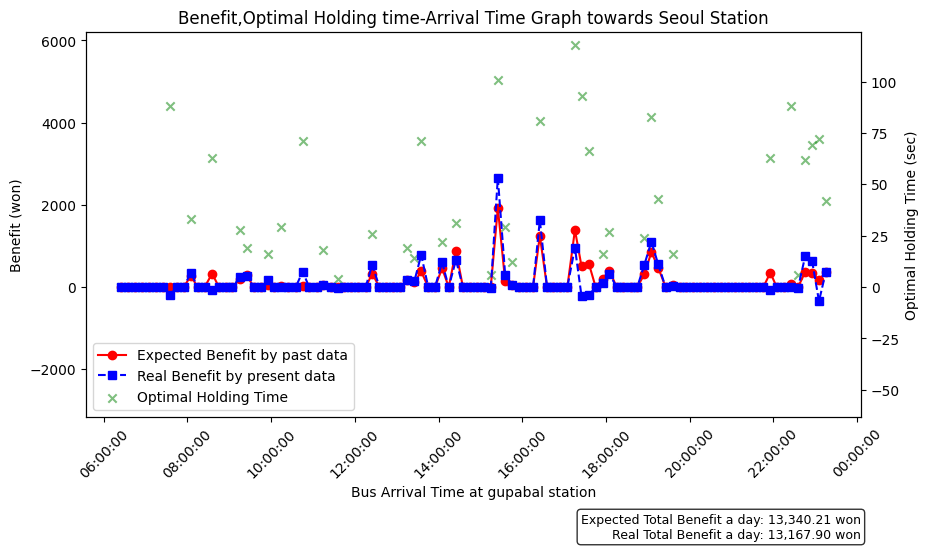

In [ ]:
'''셀9
결과 시각화
그래프 그리기
'''
graph_dict={}
for i in range(len(bus_dict)):
    graph_dict[bus_dict[f"bus{i}"].first_start_time + timedelta(seconds=bus_dict[f"bus{i}"].start_time+Bus708_south.route_time[Bus708_south.point_idx])]=[
        bus_dict[f"bus{i}"].optimal_time,
        bus_dict[f"bus{i}"].pi,
        bus_int_dict[f"bus{i}"].pi,
    ]

# 그래프 데이터 준비
x_values = list(graph_dict.keys())  # 시간 리스트
optimal_times = [50*v[0] for v in graph_dict.values()]  # 막대그래프 값
pi_values_1 = [v[1] for v in graph_dict.values()]  # 첫 번째 꺾은선 그래프 값
pi_values_2 = [v[2] for v in graph_dict.values()]  # 두 번째 꺾은선 그래프 값

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(10, 5))

# 꺾은선 그래프 (pi 값들)
ax1.plot(x_values, pi_values_1, color='red', marker='o', linestyle='-', label="Expected Benefit by past data")
ax1.plot(x_values, pi_values_2, color='blue', marker='s', linestyle='--', label='Real Benefit by present data')
# 점 그래프 (optimal_time)
ax1.scatter(x_values, optimal_times, color='green', alpha=0.5, label='Optimal Holding Time', marker='x')
# X축 시간 포맷
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
plt.xticks(rotation=45)

# 왼쪽 밑에 박스를 위한 y값 조정
current_ylim = ax1.get_ylim()
ax1.set_ylim(current_ylim[0] - 2500, current_ylim[1])

# 축 레이블 설정
ax1.set_xlabel("Bus Arrival Time at gupabal station")
ax1.set_ylabel("Benefit (won)", color='black')

# 범례 추가
ax1.legend(loc='lower left')

# 오른쪽 y축 추가 및 왼쪽 y축의 1/50 스케일로 설정
ax2 = ax1.twinx()
left_ylim = ax1.get_ylim()
ax2.set_ylim(left_ylim[0] / 50, left_ylim[1] / 50)
ax2.set_ylabel("Benefit (won)", color='black')
ax2.set_ylabel("Optimal Holding Time (sec)", color='black')
plt.title('Benefit,Optimal Holding time-Arrival Time Graph towards Seoul Station')

## 오른쪽 아래 텍스트 (범례처럼)
ax1.text(
    1.0, -0.25,  # x, y (axes 좌표계 기준)
    f"Expected Total Benefit a day: {total_pi:,.2f} won\nReal Total Benefit a day: {total_int_pi:,.2f} won",
    transform=ax1.transAxes,  # 축 기준 좌표
    ha='right', va='top',
    fontsize=9,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# 그래프 표시
plt.show()

#위 코드는 서울역 방면의 실제 상황 시뮬레이션에 대한 코드입니다.

#논문에 나온 것과 같이 변수를 수정하는 방법
#1.진관 차고지 방면으로 수정
데이터 로드 다음 셀부터 모든 셀(셀6,7,8,9)에 대하여 Bus708_south를 Bus708_north로 수정.
#2. 지하철-버스 환승객 scaling
사전에 변수를 정의하는 셀(셀2)의 마지막 행인
probabilities *=1에서 1을 scaling up 하고자 하는 숫자로 조정. 2로 조정시 지하철-버스 환승객이 2배가 됨.
#3. 배차간격 조정
버스 클레스 정의 셀(셀3)에서 interval을 원하는 배차간격(초)로 수정
#4. 분석 정류장 이후 정류장 삭제
이익 계산하는 셀(셀8)에서     
for j in range(Bus708_south.point_idx, len(Bus708_south.route)):
부분의 "len(Bus708_south.route)"을 "len(Bus708_south.route)-(제거하고자 하는 정류장수)"로 변경. 셀8에서 총 4개 부분을 모두 수정해야함.
#5. 시점이라는 가정
이익 계산하는 셀(셀8)에서
pi = (-(BETA * bus.in_person + BETA * loss_person_0 + ALPAH * loss_person_over1) * t + plus)부분의 "bus.in_person"을 0으로 변경.
pi가 나오는 부분이 총 2개 있으므로 2개 부분 모두 수정 필요.